# Demo loading data and creating heuristic

This demo will take you through the following steps:
- Query data from Big Query using datalab.bigquery
- Create Pandas dataframe and generate descriptive statistics
- Visualize your data using Matplotlib
- Create first heuristic as a benchmark

In [1]:
#import the needed packages. 

#BigQuery package
import datalab.bigquery as bq

#Data Libraries 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

%matplotlib inline

# Fetch the Data

In [2]:
%%bq query --name data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(pickup_datetime as date)) AS trip_dayname,
    COUNT(*) as trip_count,
    SUM(tolls_amount + fare_amount) AS total_fare_amount 
FROM `nyc-tlc.yellow.trips`
WHERE
    EXTRACT(YEAR FROM pickup_datetime) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek
;

# Data Vsualization

We are using Google Charts to create the first visualization. You can find more information here:
https://goo.gl/4Eytmi

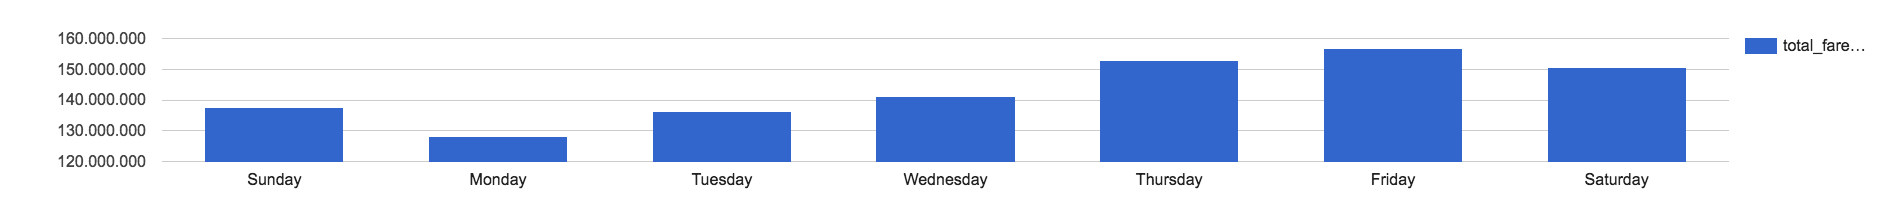

In [3]:
#Create first bar charts to visualize when people spend the most money

%chart columns --data data --fields trip_dayname,total_fare_amount

# Get a set with valid Records

In [4]:
%sql --module query

SELECT 
    pickup_datetime, 
    EXTRACT(DAYOFWEEK FROM pickup_datetime) AS pickup_dayofweek, 
    EXTRACT(HOUR FROM pickup_datetime) AS pickup_hour, 
    pickup_longitude, 
    pickup_latitude, 
    dropoff_longitude, 
    dropoff_latitude, 
    passenger_count, 
    tolls_amount + fare_amount AS fare_amount 
FROM `nyc-tlc.yellow.trips` 
WHERE 
    trip_distance > 0 
AND fare_amount >= 2.5 
AND pickup_longitude  > -78 
AND pickup_longitude  < -70 
AND dropoff_longitude  > -78 
AND dropoff_longitude  < -70 
AND pickup_latitude  > 37 
AND pickup_latitude < 45 
AND dropoff_latitude  > 37 
AND dropoff_latitude  < 45 
AND passenger_count  > 0 
AND EXTRACT(YEAR FROM pickup_datetime) = 2015
AND MOD(ABS(FARM_FINGERPRINT(STRING(pickup_datetime))), $STEP_SIZE) = 1

In [5]:
#Create a sample size consisting of 20000 rows

sample_size = 20000

VALID_ROW_COUNT = 75280784
step_size = int(VALID_ROW_COUNT / sample_size)-1
print("Sample Size = {}".format(sample_size))

Sample Size = 20000


# From Big Query to Pandas dataframe

In [6]:
#We can use the to_dataframe function to take data from Big Query and create a Pandas dataframe.
#Which we can thenuse to print the first five rows. 

trips = bq.Query(query,STEP_SIZE = step_size).to_dataframe(dialect='standard').loc[:sample_size-1,:]

days = ['null', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
pickup_dayofweek = list(map(lambda index: days[index],trips['pickup_dayofweek']))
trips['pickup_dayofweek'] = pickup_dayofweek
trips.head(5)

,pickup_datetime,pickup_dayofweek,pickup_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2015-02-15 00:01:12,Sun,0,-73.981003,40.767605,-73.941849,40.817726,1,20.5
1,2015-02-15 00:01:12,Sun,0,-73.982895,40.762642,-74.000237,40.720615,1,16.0
2,2015-02-15 00:01:12,Sun,0,-73.980721,40.733948,-73.952110,40.773232,1,10.0
3,2015-02-15 00:01:12,Sun,0,-73.988594,40.722668,-73.948273,40.711227,1,11.0
4,2015-02-15 00:01:12,Sun,0,-73.959511,40.776913,-73.992119,40.749149,1,13.0


In [7]:
#Describe Dataset
trips.describe()

,pickup_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,13.352400,-73.974084,40.751262,-73.973726,40.751832,1.680500,12.883515
std,6.275196,0.036699,0.027613,0.035345,0.031103,1.343283,11.171196
min,0.000000,-74.183403,40.587166,-74.424873,40.510925,1.000000,2.500000
25%,9.000000,-73.992043,40.737228,-73.991196,40.736246,1.000000,6.500000
50%,14.000000,-73.981937,40.754057,-73.980011,40.754776,1.000000,9.500000
75%,19.000000,-73.967329,40.768624,-73.963585,40.769311,2.000000,14.500000
max,23.000000,-73.532608,40.890175,-73.096634,41.019985,6.000000,234.000000


In [8]:
#Haversine formula to compute distance "as the crow flies".  Taxis can't fly of course.
def compute_haversine_distance(lat1, lon1, lat2, lon2):
    distance = np.degrees(np.arccos(np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1)))) * 60 * 1.515 * 1.609344
    return distance
  
haversine_distance = compute_haversine_distance(
    trips.pickup_latitude,
    trips.pickup_longitude,
    trips.dropoff_latitude,
    trips.dropoff_longitude)

# Now it's time to realy explore and visualize our data

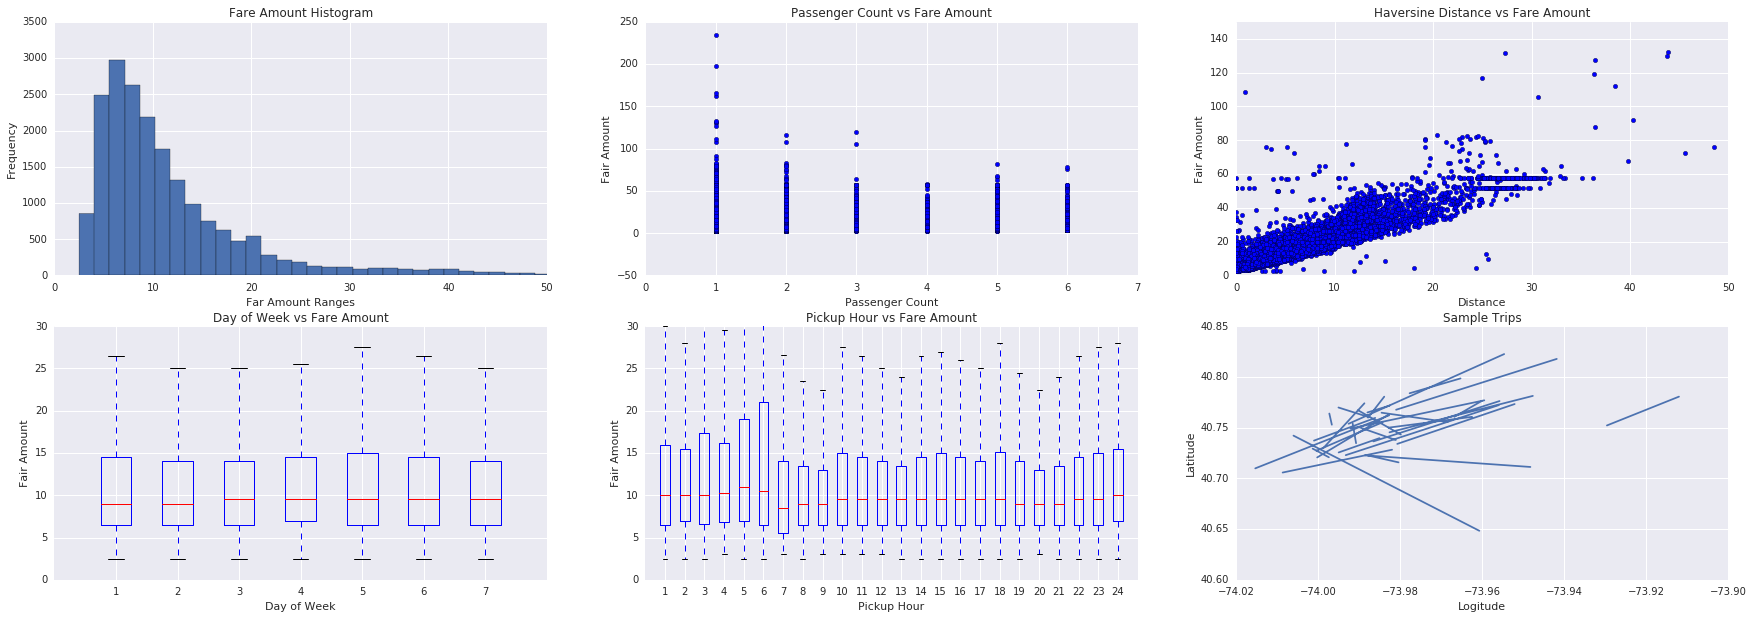

In [9]:
plt.close('all')
plt.figure(figsize=(30, 10))

# Fare Amount Distribution
plt.subplot(2,3,1)
plt.title("Fare Amount Histogram")
plt.hist(trips.fare_amount, bins=150)
plt.axis([0, 50, 0, 3500])
plt.xlabel("Far Amount Ranges")
plt.ylabel("Frequency")
# ---------------------------

# Passenger Count vs Fare Amount
plt.subplot(2,3,2)
plt.title("Passenger Count vs Fare Amount")
plt.scatter(trips.passenger_count,trips.fare_amount)
plt.xlabel("Passenger Count")
plt.ylabel("Fair Amount")
# ---------------------------

# Haversine Distance vs Fare Amount
plt.subplot(2,3,3)
plt.title("Haversine Distance vs Fare Amount")
plt.scatter(haversine_distance,trips.fare_amount)
plt.axis([0, 50, 0, 150])
plt.xlabel("Distance")
plt.ylabel("Fair Amount")
# ---------------------------

# Day of Week vs Fare Amount Boxplot
plt.subplot(2,3,4)
plt.title("Day of Week vs Fare Amount")

data = []
for i in range(1,8):
    dayofweek = days[i]
    data = data + [trips.fare_amount[trips.pickup_dayofweek == dayofweek].values]

plt.boxplot(data)
plt.axis([0, 8, 0, 30])
plt.xlabel("Day of Week")
plt.ylabel("Fair Amount")
# ---------------------------

# Pickup Hour vs Fare Amount Boxplot
plt.subplot(2,3,5)
plt.title("Pickup Hour vs Fare Amount")

data = []
for i in range(0,24):
    data = data + [trips.fare_amount[trips.pickup_hour == i].values]

plt.boxplot(data)
plt.axis([0, 25, 0, 30])
plt.xlabel("Pickup Hour")
plt.ylabel("Fair Amount")

# ---------------------------

# Sample Trips

plt.subplot(2,3,6)
plt.title("Sample Trips")


def showrides(df, numlines):
    lats = []
    lons = []
    for iter, row in df[:numlines].iterrows():
        lons.append(row['pickup_longitude'])
        lons.append(row['dropoff_longitude'])
        lons.append(None)
        lats.append(row['pickup_latitude'])
        lats.append(row['dropoff_latitude'])
        lats.append(None)
    
    plt.xlabel("Logitude")
    plt.ylabel("Latitude")
    plt.plot(lons, lats)

showrides(trips, 30)

plt.show()

# Time for data partitioning

In [13]:
#We now are going to create a train, validation and tests dataset that we can use for modeling. 
header_names = trips.columns.values
print(header_names)
print("")

shuffled = trips.sample(frac=1)
trainsize = int(len(shuffled) * 0.40)
validsize = int(len(shuffled) * 0.10)


df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]
df_test = shuffled.iloc[(trainsize+validsize):, :]

print("training instance:{}".format(len(df_train)))
print("validation instance:{}".format(len(df_valid)))
print("test instance:{}".format(len(df_test)))

[u'pickup_datetime' u'pickup_dayofweek' u'pickup_hour' u'pickup_longitude'
 u'pickup_latitude' u'dropoff_longitude' u'dropoff_latitude'
 u'passenger_count' u'fare_amount']

training instance:8000
validation instance:2000
test instance:10000


# Save the datasets local

In [16]:
#Save data local. 
df_train.to_csv('/content/datalab/data/train-data.csv', header=False, index_label=False, index=False)
df_valid.to_csv('/content/datalab/data/valid-data.csv', header=False, index_label=False, index=False)
df_test.to_csv('/content/datalab/data/test-data.csv', header=False, index_label=False, index=False)

In [18]:
%%bash
ls /content/datalab/data

test-data.csv
train-data.csv
valid-data.csv


In [19]:
#verify that data is written
df_train = pd.read_csv('/content/datalab/data/train-data.csv', header=None, names=header_names)
df_valid = pd.read_csv('/content/datalab/data/valid-data.csv', header=None, names=header_names)
df_test = pd.read_csv('/content/datalab/data/test-data.csv', header=None, names=header_names)

print("training instance:{}".format(len(df_train)))
print("validation instance:{}".format(len(df_valid)))
print("test instance:{}".format(len(df_test)))

training instance:8000
validation instance:2000
test instance:10000


# Upload datasets to Google Cloud Storage (GCS)

In [21]:
%%bash
gsutil -m cp /content/datalab/data/*-data.csv gs://erwinh-demobucket/data/nyc-taxifare

Copying file:///content/datalab/data/test-data.csv [Content-Type=text/csv]...
Copying file:///content/datalab/data/train-data.csv [Content-Type=text/csv]...
Copying file:///content/datalab/data/valid-data.csv [Content-Type=text/csv]...
/ [3/3 files][  1.7 MiB/  1.7 MiB] 100% Done                                    
Operation completed over 3 objects/1.7 MiB.                                      


# Build a simple Heuristic to set the baseline for the RMSE

- First, we are going to compute the average rate per kilometer ($/km), as (mean fare amount) / (mean haversine distance)
- Second, we are going to compute estimated fare amount for each trip, as (average rate) X (haversine distance)
- Third, we compute the Root Mean Squared Error (RMSE) over the datasets, which is going to be our baseline to (try to) beat!

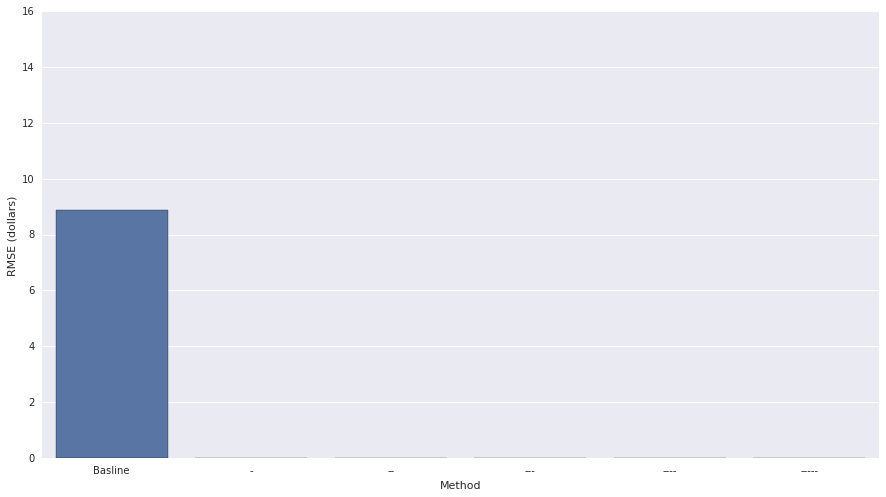

In [22]:
df = pd.DataFrame({
              'Method' : pd.Series(['Basline', '-', '--', '---', '----', '-----']),
              'RMSE': pd.Series([8.89, 0, 0, 0, 0, 0]) })

plt.figure(figsize=(15, 8))
plt.axis([0, 7, 0, 16])
ax = sns.barplot(data=df, x='Method', y='RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Method')